# Vizuara AI Labs: Hand written text classification Project

This notebooks shows how to define and train a simple Neural-Network with PyTorch and use it via skorch with SciKit-Learn.

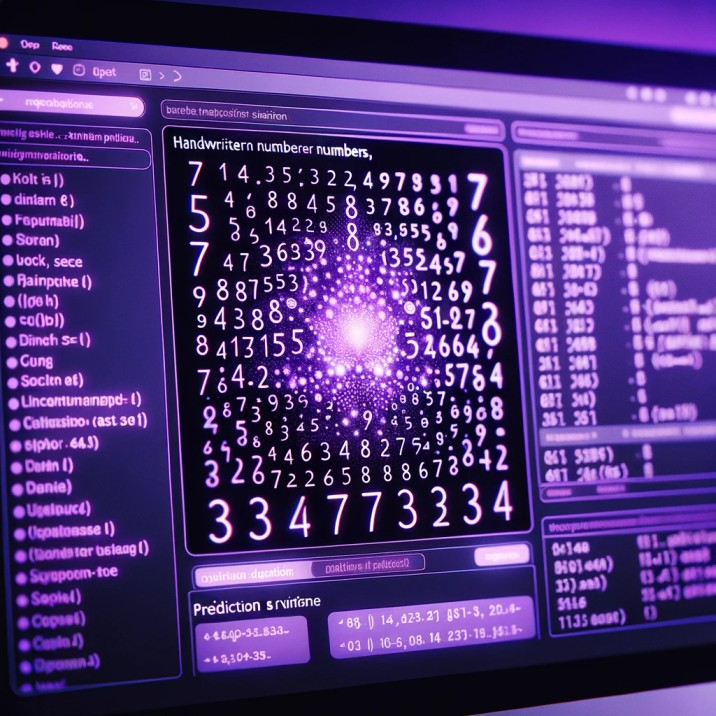

**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb), we recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

If you are running in colab, you should install the dependencies and download the dataset by running the following cell:

In [1]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
except ImportError:
    pass

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## Loading Data
Using SciKit-Learns ```fetch_openml``` to load MNIST data.

In [3]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=False)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
mnist.data.shape

(70000, 784)

## Preprocessing Data

Each image of the MNIST dataset is encoded in a 784 dimensional vector, representing a 28 x 28 pixel image. Each pixel has a value between 0 and 255, corresponding to the grey-value of a pixel.<br />
The above ```featch_mldata``` method to load MNIST returns ```data``` and ```target``` as ```uint8``` which we convert to ```float32``` and ```int64``` respectively.

In [5]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

To avoid big weights that deal with the pixel values from between [0, 255], we scale `X` down. A commonly used range is [0, 1].

In [6]:
X /= 255.0

In [7]:
X.min(), X.max()

(0.0, 1.0)

Note: data is not normalized.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [10]:
X_train.shape, y_train.shape

((52500, 784), (52500,))

### Print a selection of training images and their labels

In [11]:
def plot_example(X, y):
    """Plot the first 100 images in a 10x10 grid."""
    plt.figure(figsize=(15, 15))  # Set figure size to be larger (you can adjust as needed)

    for i in range(10):  # For 10 rows
        for j in range(10):  # For 10 columns
            index = i * 10 + j
            plt.subplot(10, 10, index + 1)  # 10 rows, 10 columns, current index
            plt.imshow(X[index].reshape(28, 28))  # Display the image
            plt.xticks([])  # Remove x-ticks
            plt.yticks([])  # Remove y-ticks
            plt.title(y[index], fontsize=8)  # Display the label as title with reduced font size

    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust spacing (you can modify as needed)
    plt.tight_layout()  # Adjust the spacing between plots for better visualization
    plt.show()  # Display the entire grid


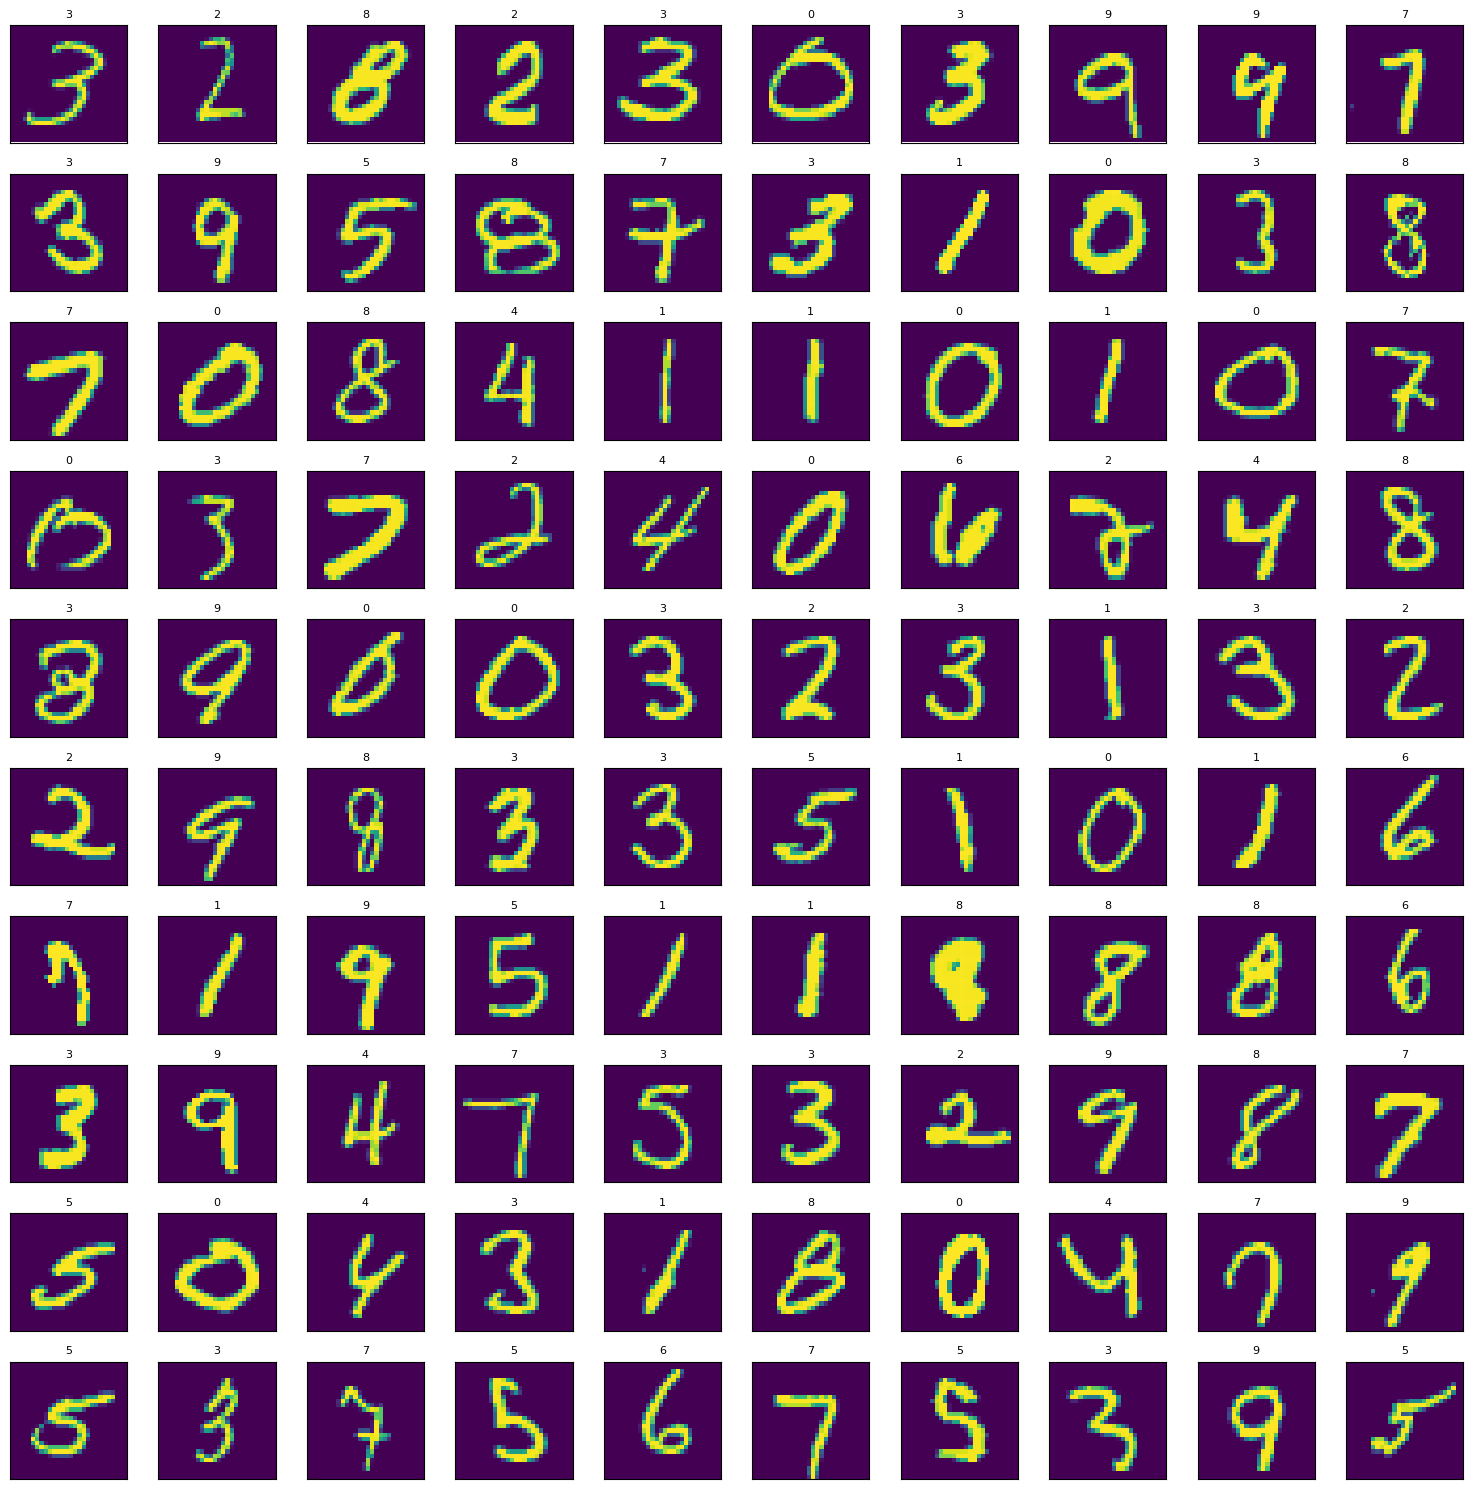

In [12]:
plot_example(X_train, y_train)

## Build Neural Network with PyTorch
Simple, fully connected neural network with one hidden layer. Input layer has 784 dimensions (28x28), hidden layer has 98 (= 784 / 8) and output layer 10 neurons, representing digits 0 - 9.

In [13]:
# pip install torch

In [14]:
import torch
from torch import nn
import torch.nn.functional as F

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
device

'cpu'

In [17]:
mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))

In [18]:
mnist_dim, hidden_dim, output_dim

(784, 98, 10)

A Neural network in PyTorch's framework.

In [19]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

skorch allows to use PyTorch's networks in the SciKit-Learn setting:

In [20]:
# pip install skorch

In [21]:
from skorch import NeuralNetClassifier

In [22]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=20,
    lr=0.1,
    device=device,
)

In [23]:
net.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8309       0.8865        0.4049  1.7326
      2        0.4323       0.9124        0.3047  1.5646
      3        0.3606       0.9215        0.2682  1.5560
      4        0.3191       0.9297        0.2424  1.5045
      5        0.2969       0.9360        0.2192  1.5467
      6        0.2760       0.9395        0.2040  1.5301
      7        0.2596       0.9440        0.1911  1.4833
      8        0.2463       0.9476        0.1776  1.4834
      9        0.2357       0.9501        0.1697  1.4998
     10        0.2272       0.9521        0.1650  1.5650
     11        0.2198       0.9539        0.1569  1.5324
     12        0.2074       0.9547        0.1536  1.5167
     13        0.2037       0.9558        0.1487  1.5355
     14        0.1985       0.9545        0.1468  1.5999
     15        0.1960       0.9583        0.1392  1.5350
     16        0.1885       0.9

## Prediction

In [24]:
from sklearn.metrics import accuracy_score

In [25]:
y_pred = net.predict(X_test)

In [26]:
accuracy_score(y_test, y_pred)

0.9614857142857143

An accuracy of about 96% for a network with only one hidden layer is not too bad.

Let's take a look at some predictions that went wrong:

In [27]:
error_mask = y_pred != y_test

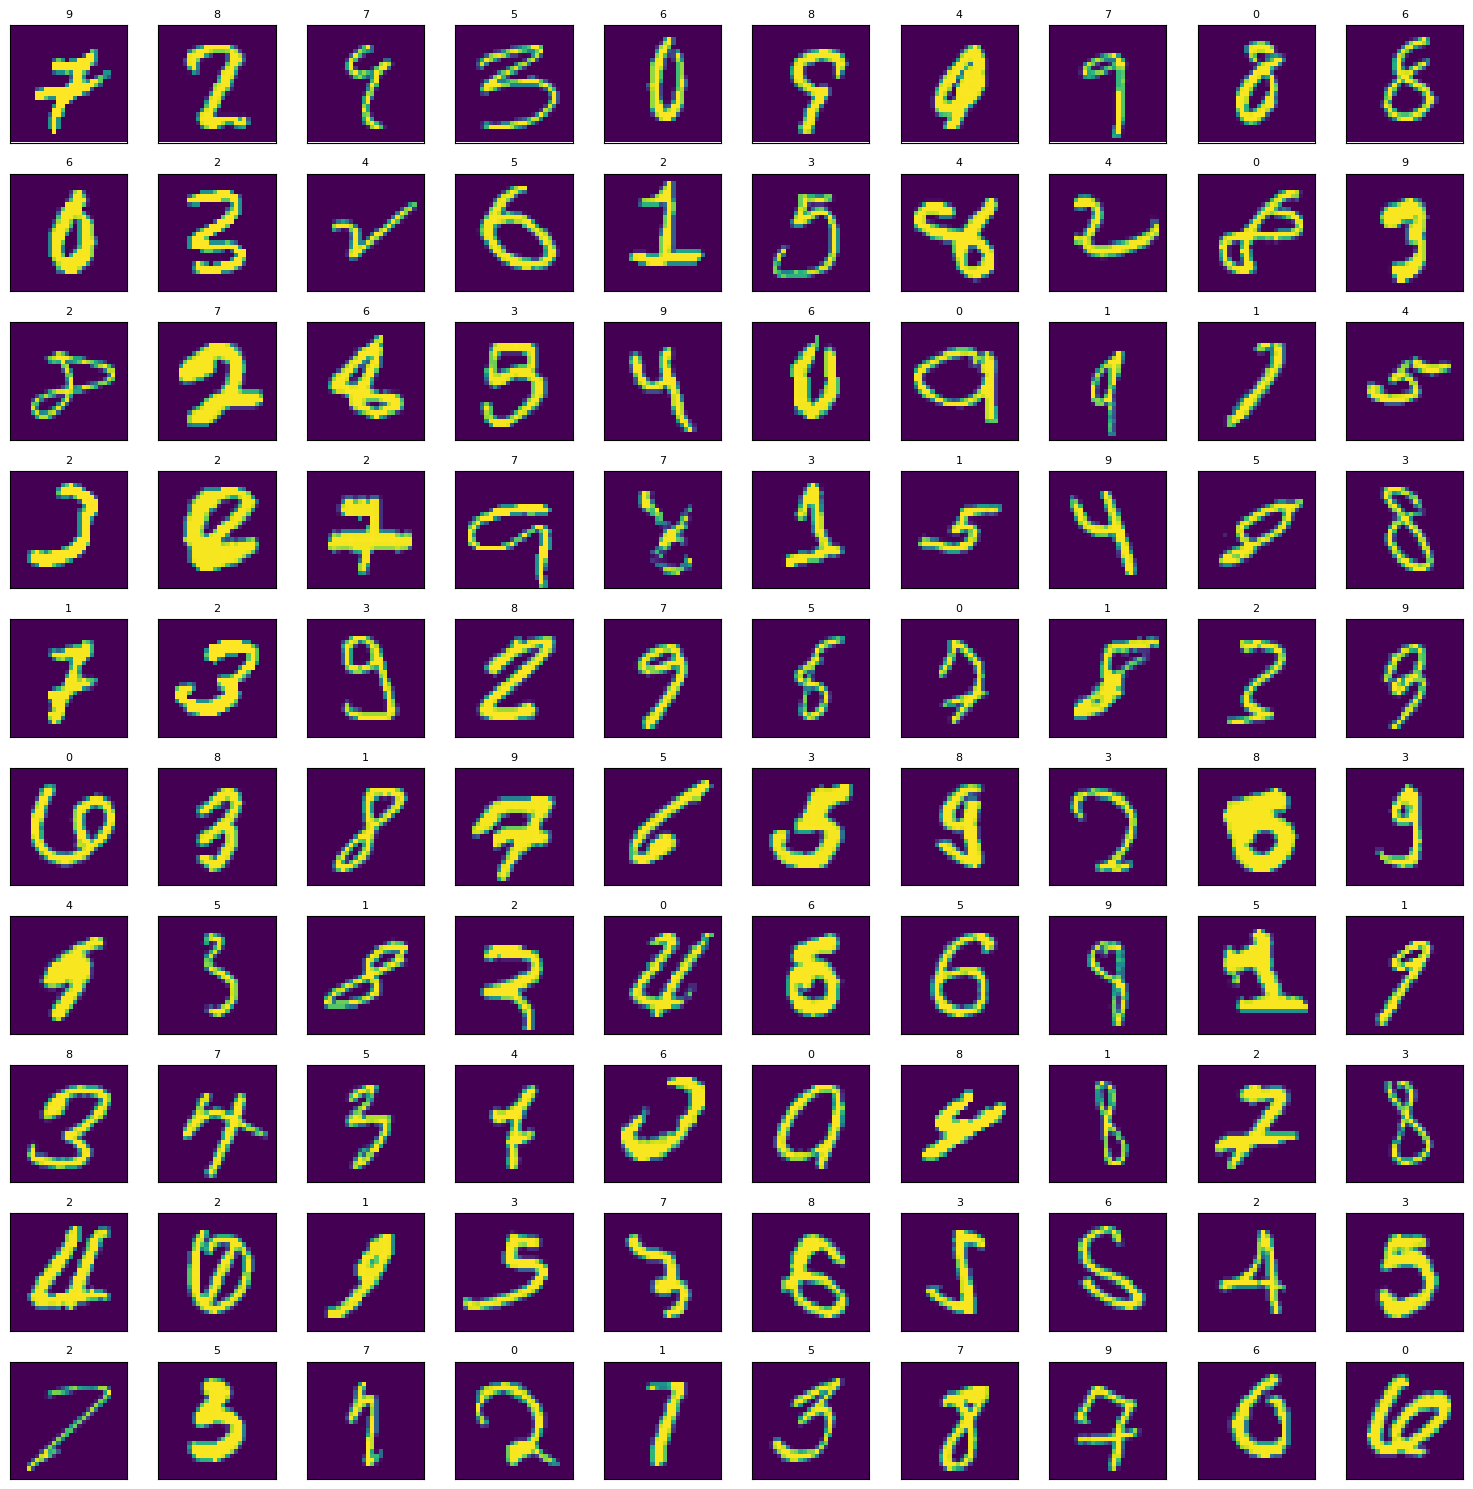

In [28]:
plot_example(X_test[error_mask], y_pred[error_mask])



```
# This is formatted as code
```

# Convolutional Network
PyTorch expects a 4 dimensional tensor as input for its 2D convolution layer. The dimensions represent:
* Batch size
* Number of channel
* Height
* Width

As initial batch size the number of examples needs to be provided. MNIST data has only one channel. As stated above, each MNIST vector represents a 28x28 pixel image. Hence, the resulting shape for PyTorch tensor needs to be (x, 1, 28, 28).

In [29]:
XCnn = X.reshape(-1, 1, 28, 28)

In [30]:
XCnn.shape

(70000, 1, 28, 28)

In [31]:
XCnn_train, XCnn_test, y_train, y_test = train_test_split(XCnn, y, test_size=0.25, random_state=42)

In [32]:
XCnn_train.shape, y_train.shape

((52500, 1, 28, 28), (52500,))

In [33]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [34]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn,
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [35]:
cnn.fit(XCnn_train, y_train)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.4339       0.9723        0.0900  22.3570
      2        0.1630       0.9784        0.0678  24.0396
      3        0.1277       0.9812        0.0572  25.3752
      4        0.1134       0.9847        0.0493  21.1229
      5        0.1003       0.9858        0.0466  19.8616
      6        0.0945       0.9869        0.0451  18.0241
      7        0.0872       0.9871        0.0396  18.3523
      8        0.0808       0.9889        0.0386  18.6500
      9        0.0805       0.9890        0.0356  18.6345
     10        0.0749       0.9885        0.0378  25.3137


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Cnn(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv2_drop): Dropout2d(p=0.5, inplace=False)
    (fc1): Linear(in_features=1600, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=10, bias=True)
    (fc1_drop): Dropout(p=0.5, inplace=False)
  ),
)

In [36]:
y_pred_cnn = cnn.predict(XCnn_test)

In [37]:
accuracy_score(y_test, y_pred_cnn)

0.9872

An accuracy of >98% should suffice for this example!

Let's see how we fare on the examples that went wrong before:

In [38]:
accuracy_score(y_test[error_mask], y_pred_cnn[error_mask])

0.755192878338279

Over 70% of the previously misclassified images are now correctly identified.

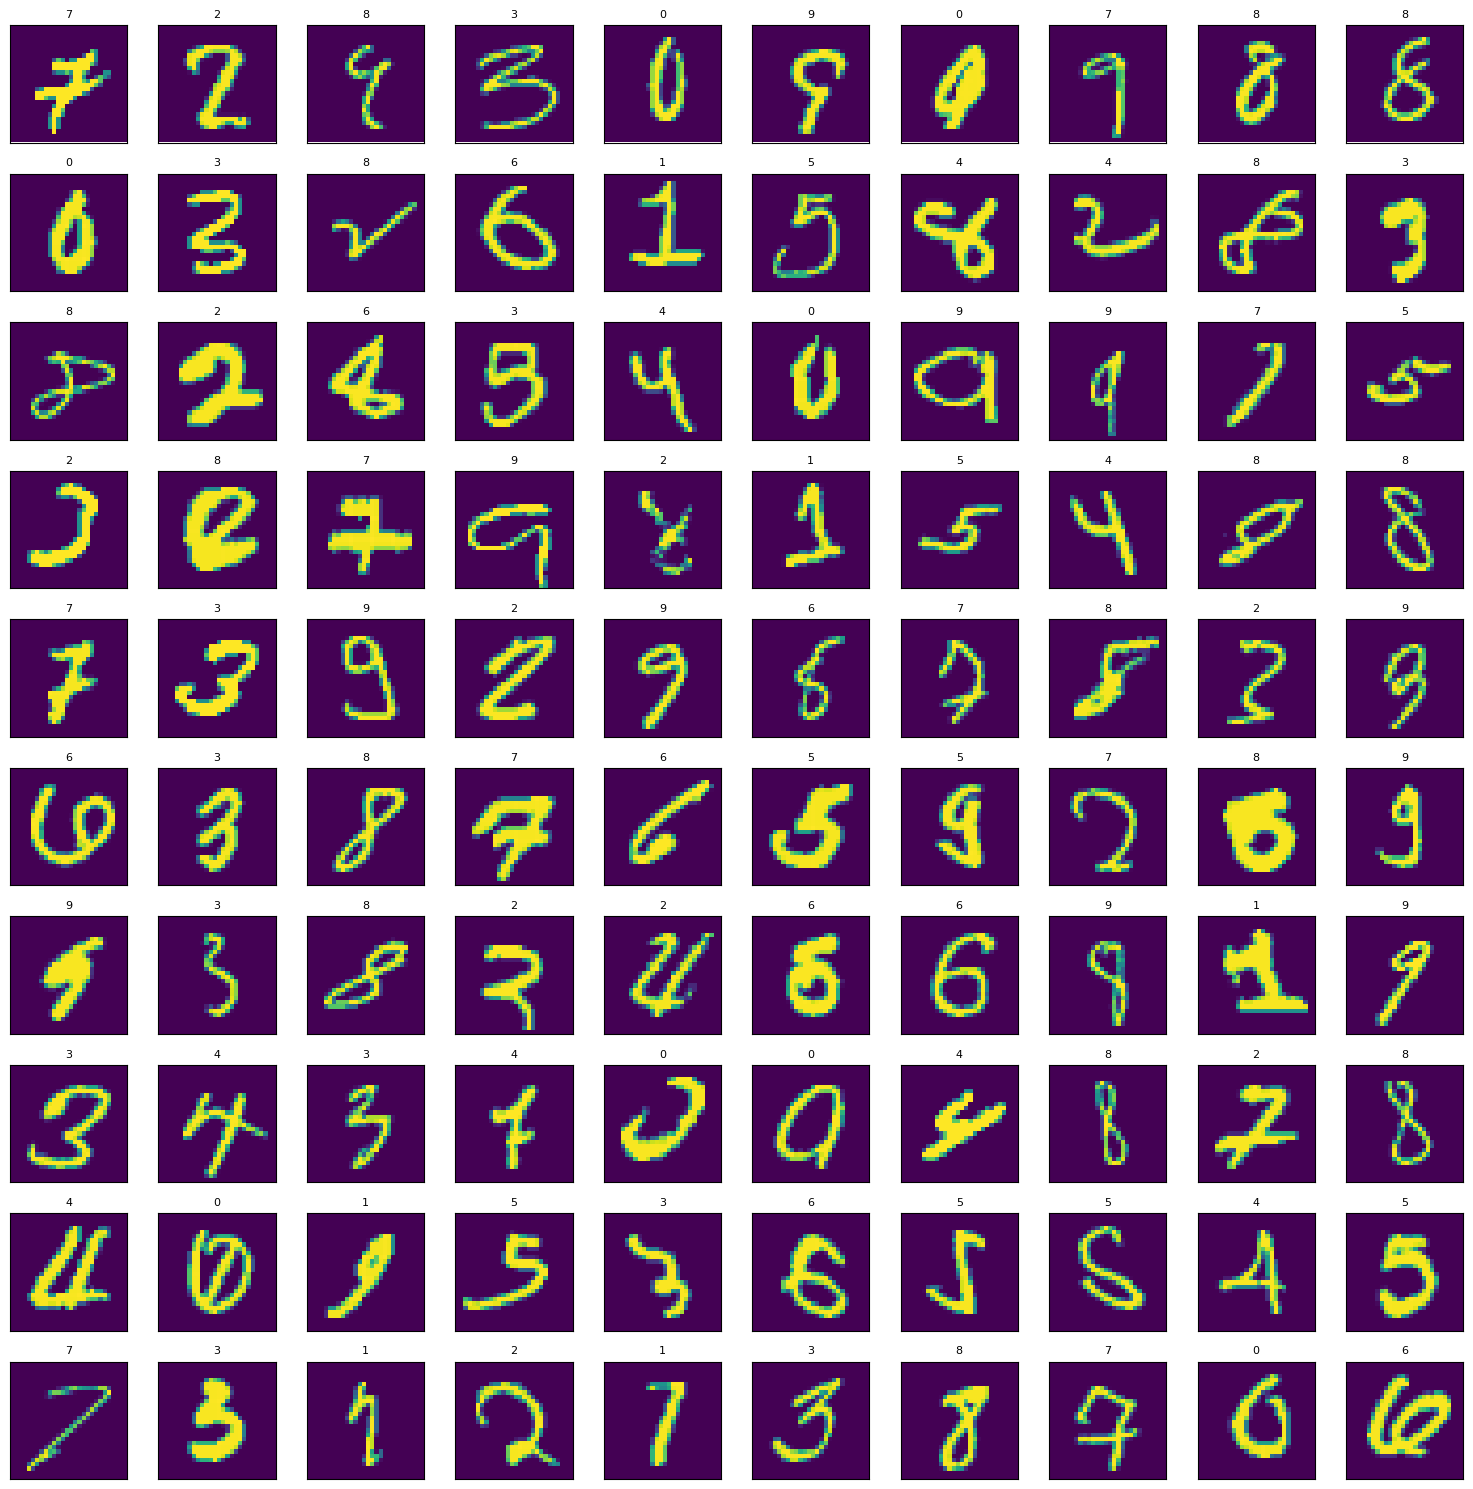

In [39]:
plot_example(X_test[error_mask], y_pred_cnn[error_mask])

In [40]:
import pickle
pickle.dump(cnn,open('C:/Users/UdayA/Documents/Projects1/Hand Writing/model.pkl','wb'))

In [42]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

  Obtaining dependency information for tensorflow-intel==2.14.0 from https://files.pythonhosted.org/packages/ad/6e/1bfe367855dd87467564f7bf9fa14f3b17889988e79598bc37bf18f5ffb6/tensorflow_intel-2.14.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow_intel-2.14.0-cp311-cp311-win_amd64.whl.metadata (4.8 kB)
  Using cached gast-0.5.4-py3-none-any.whl (19 kB)
  Obtaining dependency information for tensorboard<2.15,>=2.14 from https://files.pythonhosted.org/packages/73/a2/66ed644f6ed1562e0285fcd959af17670ea313c8f331c46f79ee77187eb9/tensorboard-2.14.1-py3-none-any.whl.metadata
  Using cached tensorboard-2.14.1-py3-none-any.whl.metadata (1.7 kB)
  Obtaining dependency information for tensorflow-estimator<2.15,>=2.14.0 from https://files.pythonhosted.org/packages/d1/da/4f264c196325bb6e37a6285caec5b12a03def489b57cc1fdac02bb6272cd/tensorflow_e

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [43]:
from tensorflow import keras

In [45]:
pip install joblib

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [46]:
import joblib

# Assuming 'cnn' is your trained skorch model
joblib.dump(cnn, 'C:/Users/UdayA/Documents/Projects1/Hand Writing/model.pkl')

['C:/Users/UdayA/Documents/Projects1/Hand Writing/model.pkl']

In [44]:
cnn.save('C:/Users/UdayA/Documents/Projects1/Hand Writing/model.hdf5')

AttributeError: 'NeuralNetClassifier' object has no attribute 'save'

In [ ]:
# pip install streamlit tensorflow  

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for streamlit from https://files.pythonhosted.org/packages/df/e2/e1c8e3abce0e819a4ef3c6a5af4ddbb1eadbca0cf2ebd5e58853edcd58bd/streamlit-1.28.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/80/6f/57d36f6507e432d7fc1956b2e9e8530c5c2d2bfcd8821bcbfae271cd6688/tensorflow-2.14.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for altair<6,>=4.0 from https://files.pythonhosted.org/packages/17/16/b12fca347ff9d062e3c44ad9641d2ec50364570a059f3078ada3a5119d7a/altair-5.1.2-py3-none-any.whl.metadata
  Obtaining dependency information for blinker<2,>=1.0.0 from https://files.pythonhosted.org/packages/fa/2a/7f3714cbc6356a0efec525ce7a0613d581072ed6eb53eb7b9754f33db807/blinker-1.7.0-py3-none-any.whl.metadata
  Obtaining dependency information for cachetools<6,>=4.0 from https://files.pythonho

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.3 requires protobuf<4,>=3.11, but you have protobuf 4.25.0 which is incompatible.
